In [1]:
#Import necessary packages

import pandas as pd
import numpy as np
import matplotlib as mpl
from pvlive_api import PVLive
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import missingno as missingno

%matplotlib inline

import statsmodels.tsa.api as tsa
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pmd

import json


from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.all import *
from sktime.forecasting.compose import *
from sktime.forecasting.model_selection import ForecastingGridSearchCV

In [2]:
#Set pandas and seaborn options

pd.set_option('display.max_columns',0)
plt.style.use('seaborn-notebook')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# MODEL

In [3]:
germany_df = pd.read_csv("data/historicgeneration.csv")
germany_df = germany_df.iloc[:-1]
germany_df.head()

,ignore,date,period,CGST,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTNEM,INTELEC,INTIFA2,INTNSL
0,FUELHH,20210629,1.0000,11577.0000,0.0000,0.0000,4529.0000,1806.0000,0.0000,75.0000,2.0000,142.0000,1706.0000,14.0000,390.0000,0.0000,2053.0000,852.0000,0.0000,846.0000,0.0000
1,FUELHH,20210629,2.0000,11173.0000,0.0000,0.0000,4465.0000,1798.0000,0.0000,72.0000,2.0000,144.0000,1706.0000,0.0000,390.0000,0.0000,1861.0000,852.0000,0.0000,846.0000,0.0000
2,FUELHH,20210629,3.0000,10911.0000,0.0000,0.0000,4444.0000,1797.0000,0.0000,70.0000,1.0000,145.0000,1706.0000,0.0000,390.0000,0.0000,1915.0000,852.0000,0.0000,846.0000,0.0000
3,FUELHH,20210629,4.0000,10533.0000,0.0000,0.0000,4456.0000,1920.0000,0.0000,70.0000,0.0000,142.0000,1706.0000,0.0000,390.0000,0.0000,2038.0000,852.0000,0.0000,846.0000,0.0000
4,FUELHH,20210629,5.0000,10269.0000,0.0000,0.0000,4458.0000,1974.0000,0.0000,70.0000,2.0000,142.0000,1706.0000,0.0000,390.0000,0.0000,2119.0000,852.0000,0.0000,846.0000,0.0000


In [4]:
germany_df.shape

(1432, 21)

In [5]:
germany_df['Period'] = germany_df['period'] * 30
germany_df['Period'] = germany_df['Period'].apply(lambda x:datetime.timedelta(minutes=x))

In [6]:
germany_df['date'] = germany_df['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
germany_df['datetime'] = germany_df['date'] + germany_df['Period']

In [7]:
print(germany_df['datetime'].min())
germany_df['datetime'].max()

2021-06-29 00:30:00


Timestamp('2021-07-28 20:00:00')

In [8]:
pvl = PVLive()
df = pvl.between(start=datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(days=30), end=datetime.datetime.now(datetime.timezone.utc), dataframe=True)

In [9]:
df.rename(columns={'generation_mw' : 'SOLAR'}, inplace=True)
df.head()

,pes_id,datetime_gmt,SOLAR
0,0,2021-07-28 19:00:00+00:00,635.0000
1,0,2021-07-28 18:30:00+00:00,1130.0000
2,0,2021-07-28 18:00:00+00:00,1590.0000
3,0,2021-07-28 17:30:00+00:00,2160.0000
4,0,2021-07-28 17:00:00+00:00,2840.0000


In [10]:
df.rename(columns={'datetime_gmt' : 'datetime'}, inplace=True)
df.head()

,pes_id,datetime,SOLAR
0,0,2021-07-28 19:00:00+00:00,635.0000
1,0,2021-07-28 18:30:00+00:00,1130.0000
2,0,2021-07-28 18:00:00+00:00,1590.0000
3,0,2021-07-28 17:30:00+00:00,2160.0000
4,0,2021-07-28 17:00:00+00:00,2840.0000


In [11]:
day_light_saving = True

In [12]:
if day_light_saving == True:
    germany_df['datetime'] = germany_df['datetime'] - datetime.timedelta(hours=1)
germany_df['datetime'] = pd.to_datetime(germany_df['datetime'], utc = True)

In [13]:
dff = pd.merge(germany_df,df,on='datetime',how='inner')

In [14]:
#Drop unnecessary columns
#solar, biomass, wind, nuclear, PS, NPSHYD
dff['low_carbon'] = dff['SOLAR'] + dff['BIOMASS'] + dff['WIND'] + dff['NUCLEAR'] + dff['PS'] + dff['NPSHYD']
dff['high_carbon'] = dff['OIL'] + dff['CGST'] + dff['COAL'] + dff['OCGT'] + dff['OTHER'] + dff['INTFR'] + dff['INTIRL'] + dff['INTNED'] + dff['INTEW'] + dff['INTNEM'] + dff['INTELEC'] + dff['INTIFA2'] + dff['INTNSL']
df_main = dff[['low_carbon', 'high_carbon', 'datetime']]
df_main.head()

,low_carbon,high_carbon,datetime
0,8463.0000,15529.0000,2021-06-28 23:30:00+00:00
1,8196.0000,15113.0000,2021-06-29 00:00:00+00:00
2,8226.0000,14851.0000,2021-06-29 00:30:00+00:00
3,8484.0000,14469.0000,2021-06-29 01:00:00+00:00
4,8621.0000,14207.0000,2021-06-29 01:30:00+00:00


In [15]:
germany_df = df_main.copy()

In [16]:
germany_df = germany_df.set_index('datetime')

In [17]:
germany_df = germany_df.iloc[1:]
germany_df

,low_carbon,high_carbon
datetime,,
2021-06-29 00:00:00+00:00,8196.0000,15113.0000
2021-06-29 00:30:00+00:00,8226.0000,14851.0000
2021-06-29 01:00:00+00:00,8484.0000,14469.0000
2021-06-29 01:30:00+00:00,8621.0000,14207.0000
2021-06-29 02:00:00+00:00,8658.0000,14073.0000
...,...,...
2021-07-28 17:00:00+00:00,16506.0000,15479.0000
2021-07-28 17:30:00+00:00,16160.0000,15210.0000
2021-07-28 18:00:00+00:00,15449.0000,15525.0000


In [18]:
germany_df['ratio'] = germany_df['low_carbon'] / germany_df['high_carbon']

In [19]:
# Save cleaned dataset as CSV file
germany_df.to_csv('data/cleaned_energy_data.csv')

# Low carbon Modeling

<AxesSubplot:xlabel='datetime'>

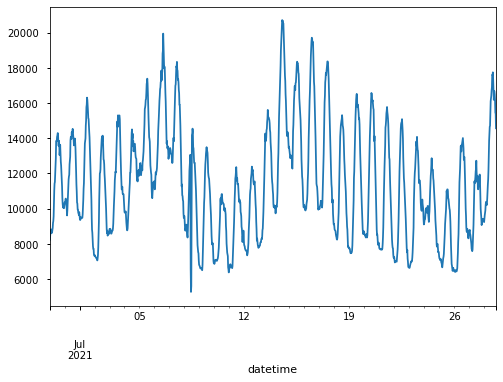

In [20]:
solar_ts = germany_df['low_carbon']
solar_ts.plot()

### Sktime

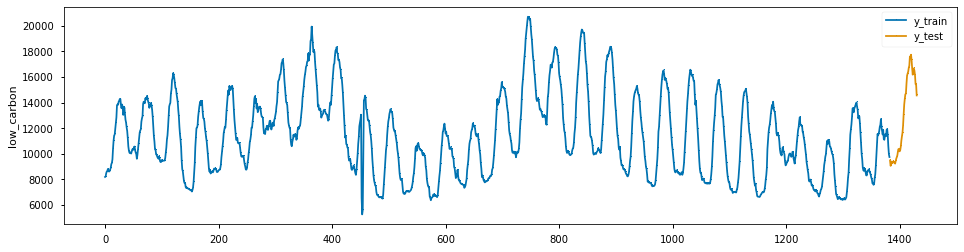

In [21]:
y = solar_ts.reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size=48)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_series(y_train, y_test, labels=["y_train", "y_test"], markers=[",", ","])
plt.show()

0.21009565763096613

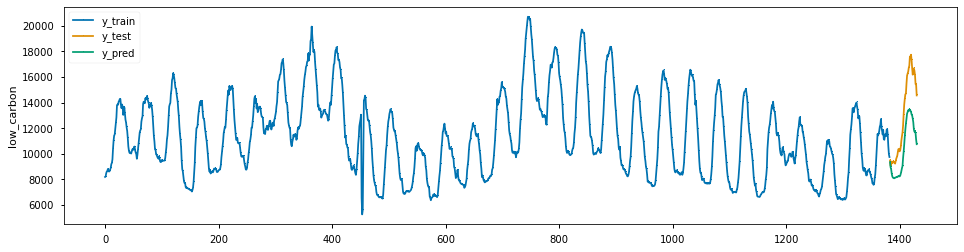

In [22]:
from xgboost import XGBRegressor
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='low_carbon'>)

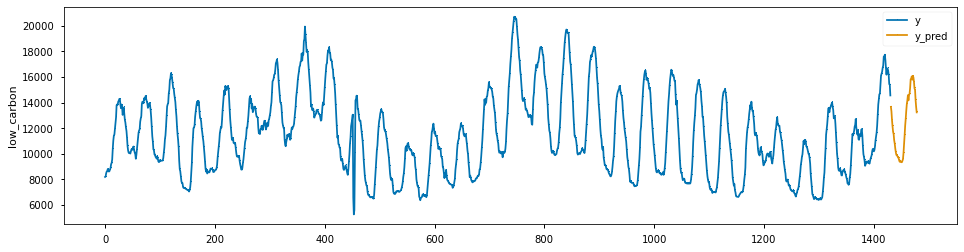

In [23]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)
y_lowcarbon = y_pred
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

# High carbon Modeling

<AxesSubplot:xlabel='datetime'>

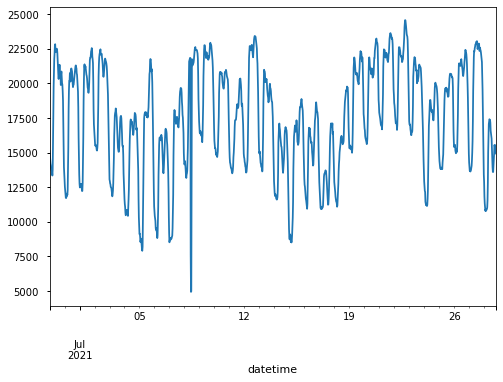

In [24]:
wind_ts = germany_df['high_carbon']
wind_ts.plot()

### Sktime

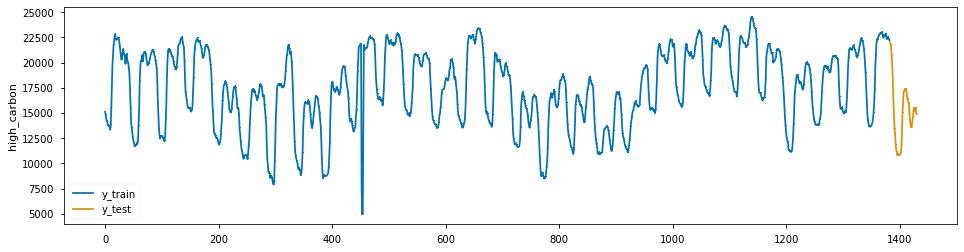

In [25]:
y = wind_ts.reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size=48)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_series(y_train, y_test, labels=["y_train", "y_test"], markers=[",", ","])
plt.show()

0.22810200955859775

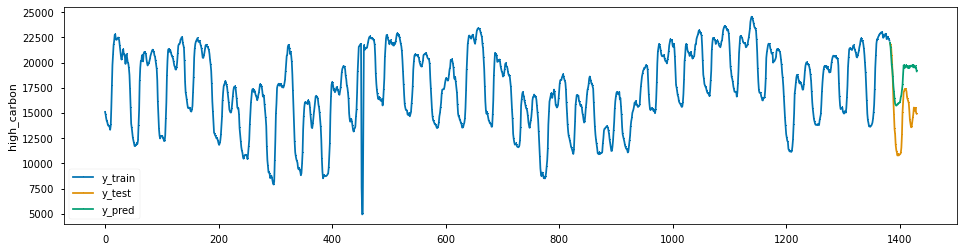

In [26]:
from xgboost import XGBRegressor

estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='high_carbon'>)

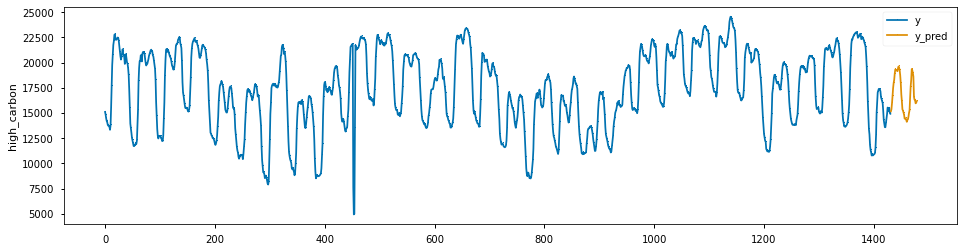

In [28]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)
y_highcarbon = y_pred
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

# Ratio modeling

<AxesSubplot:xlabel='datetime'>

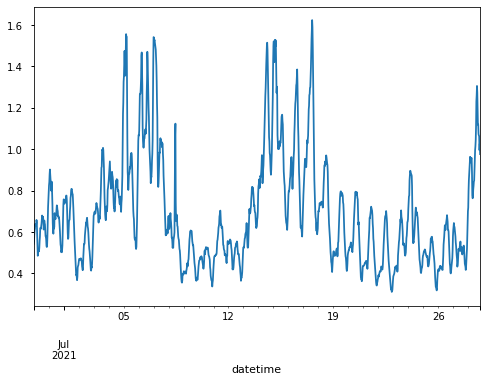

In [29]:
ratio = germany_df['ratio']
ratio.plot()

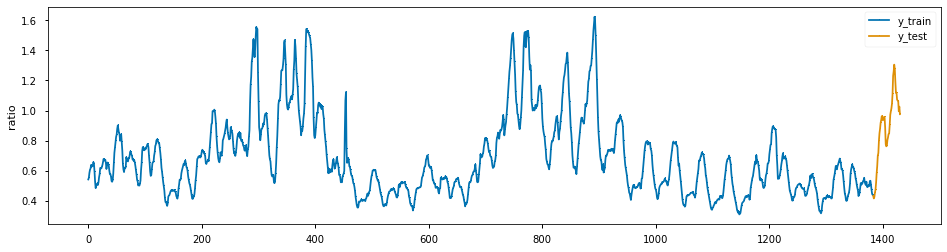

In [30]:
y = ratio.reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size=48)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_series(y_train, y_test, labels=["y_train", "y_test"], markers=[",", ","])
plt.show()

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='ratio'>)

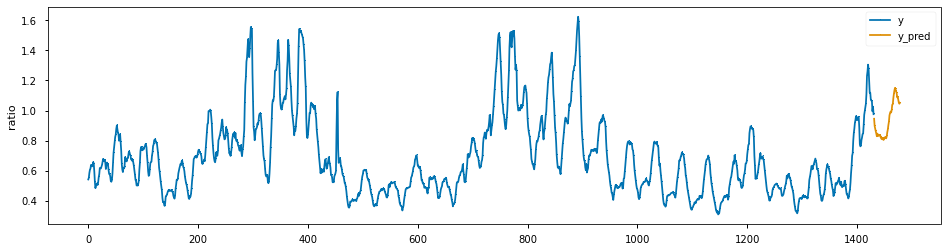

In [31]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)
y_ratio = y_pred
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

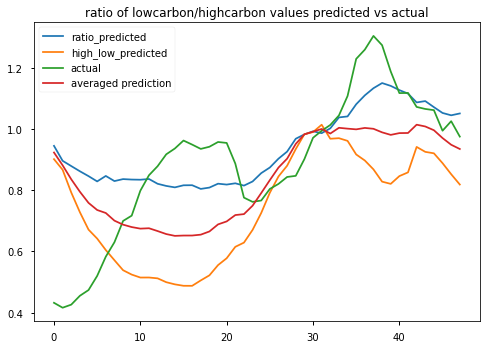

In [32]:
plt.plot(np.array(y_ratio), label = 'ratio_predicted')
plt.plot(np.array(y_lowcarbon/y_highcarbon), label = 'high_low_predicted')
plt.plot(np.array(germany_df['ratio'].iloc[-48:].reset_index(drop=True)), label = 'actual')
plt.plot((np.array(y_ratio) + np.array(y_lowcarbon/y_highcarbon))/2, label = 'averaged prediction')
plt.legend()
plt.title('ratio of lowcarbon/highcarbon values predicted vs actual')
plt.savefig('results/results_comparison')

In [33]:
df_price = pd.read_csv('data/csv_agile_A_Eastern_England.csv')

In [34]:
df_price.columns = ['datetime_utc', 'datetime_uk', 'zone', 'DNoS', 'price']

In [35]:
df_price['datetime_utc'] = pd.to_datetime(df_price['datetime_utc'], utc = True)

In [36]:
df_price.drop(columns=['datetime_uk', 'zone', 'DNoS'], inplace=True)

In [37]:
df_price = df_price.set_index('datetime_utc')

In [38]:
l = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range(germany_df.index.max() + datetime.timedelta(minutes=30), germany_df.index.max() + datetime.timedelta(days =1),
                                      freq='30T')))

In [39]:
l['ratio']= np.array(germany_df['ratio'].iloc[-48:].reset_index(drop=True))
l['ratio_predicted'] = np.array(y_ratio)
l['low_high_ratio_predicted'] = np.array(y_lowcarbon/y_highcarbon)
l['averaged_prediction'] = (np.array(y_ratio) + np.array(y_lowcarbon/y_highcarbon))/2

In [40]:
df_final = df_price.join(l, how='inner')
df_final.to_csv('data/prediction_data_withprice.csv')

In [41]:
user_input = 2# input in terms of hours

In [42]:
xx = np.asarray(df_final['ratio_predicted']/df_final['price'])

In [51]:
N = user_input * 3
moving_aves = np.convolve(xx, np.ones(N)/N, mode='valid')

In [52]:
df_final.index[np.argmax(moving_aves)]

Timestamp('2021-07-29 01:00:00+0000', tz='UTC')

In [45]:
weather = pd.read_json('energy_dashboard-master/data/weather.json').T

In [57]:
weather.columns = ['clouds', 'rain', 'datetime_uk','temperature', 'icon', 'wind']

In [58]:
weather.head()

,clouds,rain,datetime_uk,temperature,icon,wind
0,90,0,2021-07-26 09:00:00,17.8700,04d,1.0800
1,92,0.1300,2021-07-26 12:00:00,21.1800,10d,2.5000
2,91,0,2021-07-26 15:00:00,24.8700,04d,2.8200
3,94,0,2021-07-26 18:00:00,21.4600,04d,3.1100
4,100,0.1200,2021-07-26 21:00:00,19.3000,10n,2.3000


In [59]:
weather['datetime_uk'] = pd.to_datetime(weather['datetime_uk'], utc = True)

In [60]:
if day_light_saving == True:
    weather['datetime_uk'] = weather['datetime_uk'] - datetime.timedelta(hours=1)

In [61]:
weather.head()

,clouds,rain,datetime_uk,temperature,icon,wind
0,90,0,2021-07-26 08:00:00+00:00,17.8700,04d,1.0800
1,92,0.1300,2021-07-26 11:00:00+00:00,21.1800,10d,2.5000
2,91,0,2021-07-26 14:00:00+00:00,24.8700,04d,2.8200
3,94,0,2021-07-26 17:00:00+00:00,21.4600,04d,3.1100
4,100,0.1200,2021-07-26 20:00:00+00:00,19.3000,10n,2.3000
